In [1]:
from stardist.models import StarDist2D

2024-07-30 20:50:30.595372: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.


2024-07-30 20:53:19.494952: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-30 20:53:19.505610: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-07-30 20:53:19.897210: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-30 20:53:19.897271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (node05): /proc/driver/nvidia/version does not exist
2024-07-30 20:53:19.898425: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [3]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [4]:
import numpy as np
coords = np.load('/home/wpy/stereoseq/20240502-SPACseq/coord.npy')

In [5]:
x_min, y_min = np.min(coords, axis=0)
x_max, y_max = np.max(coords, axis=0)

In [16]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None
import numpy as np
    
# with Image.open('/home/wpy/stereoseq/20240502-SPACseq/D03658A6.registed.png') as img:
#     img = img.convert('L')
from skimage import color
def lum_std(img, percentile=95):
    img_lab = color.rgb2lab(img)
    light_float = img_lab[:, :, 0].astype(float)
    p = np.percentile(light_float, percentile)
    img_lab[:, :, 0] = np.clip(100 * light_float / p, 0, 100)
    img_std = color.lab2rgb(img_lab)
    img_std = img_as_ubyte(img_std)

    return img_std
    
with Image.open('/home/wpy/stereoseq/20240502-SPACseq/D03658A6.registed.png') as img:
    img = lum_std(img, percentile=80)

: 

: 

: 

In [7]:
x_min, y_max, y_min, x_max+400

(16, 17868, 465, 15675)

In [62]:
normalize?

Signature:
normalize(
    x,
    pmin=3,
    pmax=99.8,
    axis=None,
    clip=False,
    eps=1e-20,
    dtype=<class 'numpy.float32'>,
)
Docstring: Percentile-based image normalization.
File:      ~/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/csbdeep/utils/utils.py
Type:      function

Text(0.5, 1.0, 'input image')

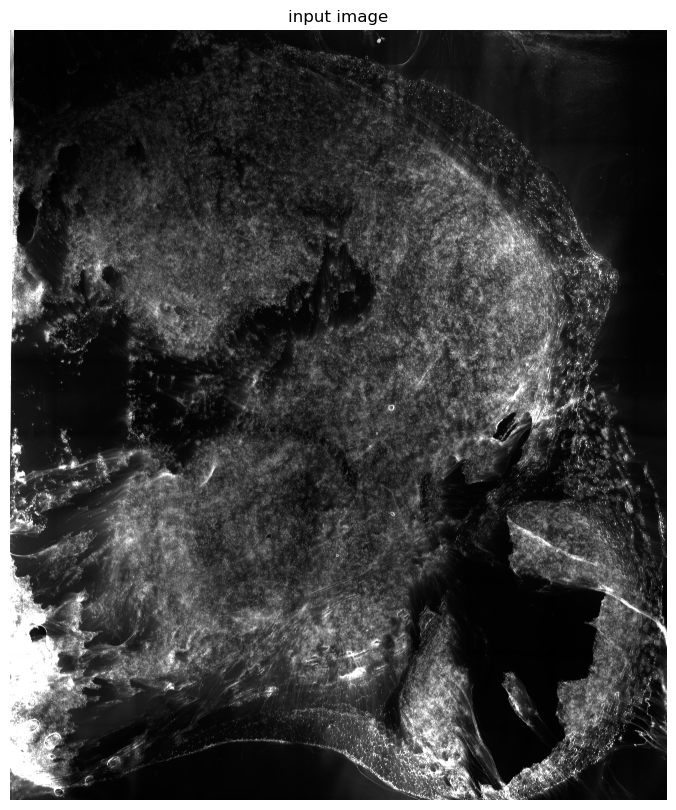

In [8]:
img_matrix = np.asarray(img)
masked_img = normalize(img_matrix[x_min:y_max, y_min:x_max+400], pmax=80)
shape_ = masked_img.shape
box_size_x, box_size_y = int(np.ceil(shape_[0] / 1)), int(np.ceil(shape_[1] / 1))
i, j = 0, 0
x_min_ = box_size_x * i
y_min_ = box_size_y * j
x_max_ = np.min((box_size_x * (i + 1) - 1, shape_[0]))
y_max_ = np.min((box_size_y * (j + 1) - 1, shape_[1]))

img_ = masked_img[x_min_:x_max_, y_min_:y_max_]

plt.figure(figsize=(20, 10))

plt.subplot(1,1,1)
plt.imshow(img_, cmap="gray")
plt.axis("off")
plt.title("input image")

In [30]:
model.predict_instances_big

Signature:
model.predict_instances_big(
    img,
    axes,
    block_size,
    min_overlap,
    context=None,
    labels_out=None,
    labels_out_dtype=<class 'numpy.int32'>,
    show_progress=True,
    **kwargs,
)
Docstring:
Predict instance segmentation from very large input images.

Intended to be used when `predict_instances` cannot be used due to memory limitations.
This function will break the input image into blocks and process them individually
via `predict_instances` and assemble all the partial results. If used as intended, the result
should be the same as if `predict_instances` was used directly on the whole image.

**Important**: The crucial assumption is that all predicted object instances are smaller than
               the provided `min_overlap`. Also, it must hold that: min_overlap + 2*context < block_size.

Example
-------
>>> img.shape
(20000, 20000)
>>> labels, polys = model.predict_instances_big(img, axes='YX', block_size=4096,
                                      

In [10]:
labels, _ = model.predict_instances_big(masked_img, axes='YX', block_size=2000, min_overlap=200, show_progress=True)

effective: block_size=(2000, 2000), min_overlap=(208, 208), context=(96, 96)


100%|██████████| 110/110 [03:13<00:00,  1.76s/it]


In [46]:
from tqdm import tqdm
label_matrix = np.zeros((shape_[0], shape_[1]))
last_max = -1
for i in range(8):
    for j in tqdm(range(8)):
        x_min = box_size_x * i
        y_min = box_size_y * j
        x_max = np.min((box_size_x * (i + 1) - 1, shape_[0]))
        y_max = np.min((box_size_y * (j + 1) - 1, shape_[1]))

        img_ = masked_img[x_min:x_max, y_min:y_max]
        labels, _ = model.predict_instances(img_)

        labels_ = np.multiply(labels > 0, labels + last_max + 1)
        last_max = np.max(labels_)

        label_matrix[x_min:x_max, y_min:y_max] = labels_

  0%|          | 0/8 [00:00<?, ?it/s]

: 

: 

: 

Text(0.5, 1.0, 'prediction + input overlay')

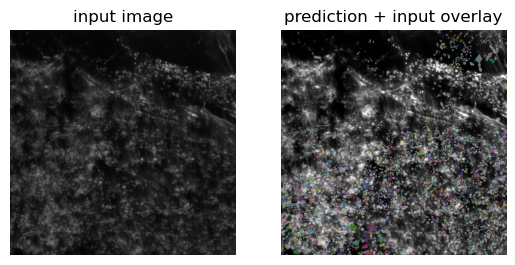

In [19]:
plt.subplot(1,2,1)
plt.imshow(img_, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels_, img=img_))
plt.axis("off")
plt.title("prediction + input overlay")

In [17]:
np.save("labels.npy", label_matrix)

In [21]:
label_matrix = np.load('labels.npy')

Text(0.5, 1.0, 'prediction + input overlay')

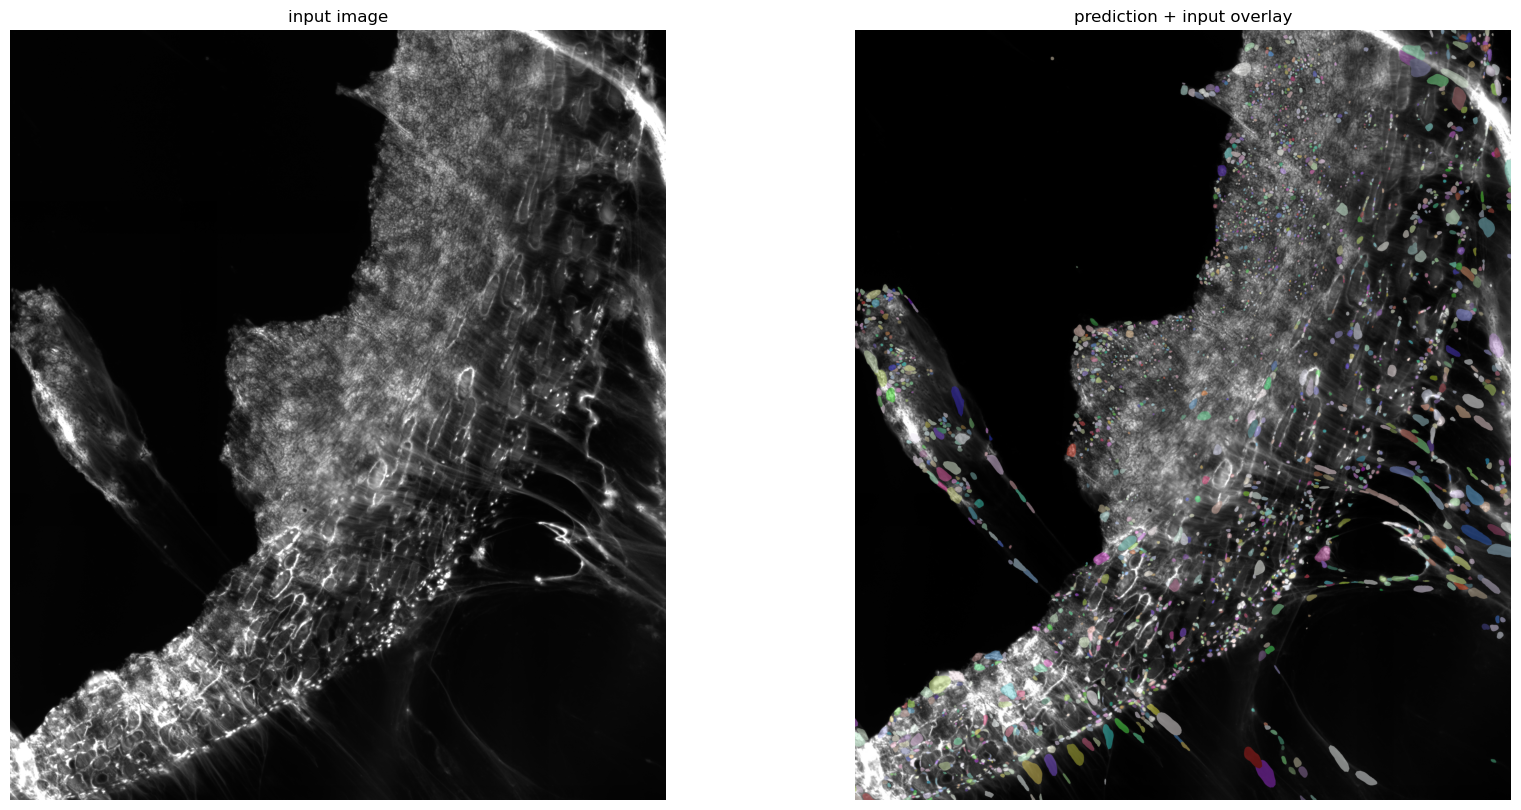

In [15]:
i, j = 3, 3
box_size_x, box_size_y = int(np.ceil(shape_[0] / 4)), int(np.ceil(shape_[1] / 4))
x_min = box_size_x * i
y_min = box_size_y * j
x_max = np.min((box_size_x * (i + 1) - 1, shape_[0]))
y_max = np.min((box_size_y * (j + 1) - 1, shape_[1]))

img_ = masked_img[x_min:x_max, y_min:y_max]
labels_ = labels[x_min:x_max, y_min:y_max]

plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
plt.imshow(img_, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels_, img=img_))
plt.axis("off")
plt.title("prediction + input overlay")